# 📘 Soal 2 & 3: Peramalan Harga BTC menggunakan ARIMA

## Dataset:
- BTC-USD (2015–2025), data harian
- Sumber: Yahoo Finance
- Total data: 3.653 baris

---

## 🟢 Soal 2: ARIMA Manual
Pendekatan manual untuk memilih parameter (p,d,q) menggunakan:
- ADF Test
- Differencing
- ACF dan PACF


# 🔹 Step 0: Load dan Eksplorasi Dataset BTC-USD

Dataset yang digunakan berisi harga penutupan harian Bitcoin (BTC) terhadap USD dari tahun 2015 hingga 2025.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Baca dataset dan tetapkan nama kolom
column_names = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df = pd.read_csv("btc_usd_2015_2025.csv", skiprows=2, names=column_names)

# Format tanggal dan tetapkan index
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
df = df.dropna(subset=['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index()
df = df[['Close']].dropna()

# Visualisasi tren awal harga BTC
plt.figure(figsize=(12, 4))
plt.plot(df['Close'], label='BTC-USD Close Price')
plt.title("BTC-USD (2015–2025)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# 🔹 Step 1: Cek Stasioneritas Menggunakan ADF Test


In [2]:
from statsmodels.tsa.stattools import adfuller

# Jalankan ADF test
adf_result = adfuller(df['Close'])

# Tampilkan hasil
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"  {key}: {value}")


ADF Statistic: -0.5477302003659125
p-value: 0.8823609708043018
Critical Values:
  1%: -3.4321567201852456
  5%: -2.862338308122449
  10%: -2.5671949518327932


# 🔹 Step 2: Transformasi Data dengan Differencing

Jika data masih belum stasioner berdasarkan ADF Test,  melakukan **first differencing** untuk menghilangkan tren dan menjadikan data stasioner.

###  Langkah:
- Hitung selisih (differencing) antar harga penutupan (`Close`)
- Visualisasikan hasil differencing
- Jalankan kembali ADF Test

In [3]:
# Hitung first differencing (d=1)
df_diff = df['Close'].diff().dropna()

# Visualisasi hasil differencing
plt.figure(figsize=(12, 4))
plt.plot(df_diff, label='Differenced Series (d=1)', color='orange')
plt.title("BTC-USD After First Differencing")
plt.xlabel("Date")
plt.ylabel("Differenced Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ADF Test ulang setelah differencing
adf_diff_result = adfuller(df_diff)
print("ADF Statistic (after differencing):", adf_diff_result[0])
print("p-value:", adf_diff_result[1])
print("Critical Values:")
for key, value in adf_diff_result[4].items():
    print(f"  {key}: {value}")


ADF Statistic (after differencing): -8.954385184245789
p-value: 8.55216363694141e-15
Critical Values:
  1%: -3.4321572194957715
  5%: -2.862338528678273
  10%: -2.567195069249532


# 🔹 Step 3: Menentukan Nilai p dan q dengan ACF & PACF



In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF dan PACF dari data setelah differencing
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(df_diff, ax=ax[0], lags=40)
ax[0].set_title("ACF Plot (Tentukan q)")

plot_pacf(df_diff, ax=ax[1], lags=40, method='ywm')
ax[1].set_title("PACF Plot (Tentukan p)")

plt.tight_layout()
plt.show()


# 🔹 Step 4: Bangun dan Latih Model ARIMA


In [6]:

from statsmodels.tsa.arima.model import ARIMA

# Tambahkan frekuensi agar warning hilang
df.index.freq = 'D'  # frekuensi harian

# Pilih parameter (ubah sesuai hasil ACF/PACF kamu)
p, d, q = 2, 1, 2  # contoh awal
#p=2 karena  ADF test setelah 1x differencing
#d=1 tren historis BTC punya memory jangka pendek
#q=2 fluktuasi responsif dari harga sebelumnya

# Bangun model ARIMA
model = ARIMA(df['Close'], order=(p, d, q))

# Latih model (bisa makan waktu jika p/q besar)
model_fit = model.fit()

# Tampilkan hasil ringkasan model
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3653
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -30570.802
Date:                Mon, 12 May 2025   AIC                          61151.604
Time:                        11:56:32   BIC                          61182.620
Sample:                    04-12-2015   HQIC                         61162.650
                         - 04-11-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2451      1.711     -0.143      0.886      -3.599       3.109
ar.L2          0.1088      0.650      0.167      0.867      -1.166       1.383
ma.L1          0.1820      1.711      0.106      0.9

# 🔹 Step 5: Prediksi dan Evaluasi Model ARIMA

In [7]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prediksi in-sample
pred = model_fit.predict(start=1, end=len(df)-1, typ='levels')

# Potong data aktual agar sejajar
actual = df['Close'].iloc[1:]

# Visualisasi hasil prediksi vs aktual
plt.figure(figsize=(12, 4))
plt.plot(actual, label='Actual Price')
plt.plot(pred, label='Predicted Price', linestyle='--')
plt.title("ARIMA(2,1,2) - Actual vs Predicted (In-Sample)")
plt.xlabel("Date")
plt.ylabel("BTC Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluasi akurasi model
mae = mean_absolute_error(actual, pred)
rmse = np.sqrt(mean_squared_error(actual, pred))
mape = np.mean(np.abs((actual - pred) / actual)) * 100

# Tampilkan hasil evaluasi
print("Mean Absolute Error (MAE):", round(mae, 2))
print("Root Mean Squared Error (RMSE):", round(rmse, 2))
print("Mean Absolute Percentage Error (MAPE):", round(mape, 2), "%")


Mean Absolute Error (MAE): 522.84
Root Mean Squared Error (RMSE): 1045.27
Mean Absolute Percentage Error (MAPE): 2.34 %


# 🟢 Soal 3 AUTO ARIMA
### Step 1: Import dan Fit Auto ARIMA


In [8]:
from pmdarima.arima import auto_arima

# Jalankan auto_arima
auto_model = auto_arima(
    df['Close'],
    seasonal=False,        # Data BTC tidak musiman
    stepwise=True,         # Gunakan pendekatan stepwise agar cepat
    trace=True             # Tampilkan proses pencarian model
)

# Tampilkan ringkasan hasil pemodelan
print(auto_model.summary())


C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=61151.695, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=61160.371, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=61147.007, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=61147.504, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=61160.097, Time=0.02 sec


C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=61148.237, Time=0.08 sec


C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=61147.982, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=61149.887, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=61146.962, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=61148.135, Time=0.05 sec


C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=61147.767, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=61147.457, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=61149.705, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.325 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3653
Model:               SARIMAX(1, 1, 0)   Log Likelihood              -30571.481
Date:                Mon, 12 May 2025   AIC                          61146.962
Time:                        11:56:47   BIC                          61159.368
Sample:                    04-12-2015   HQIC                         61151.380
                         - 04-11-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------

C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### 🔹 Soal 3-Step 2: Prediksi dan Visualisasi Auto ARIMA

- menggunakan`.predict_in_sample()` untuk membuat prediksi
- Visualisasikan hasil prediksi vs data aktual

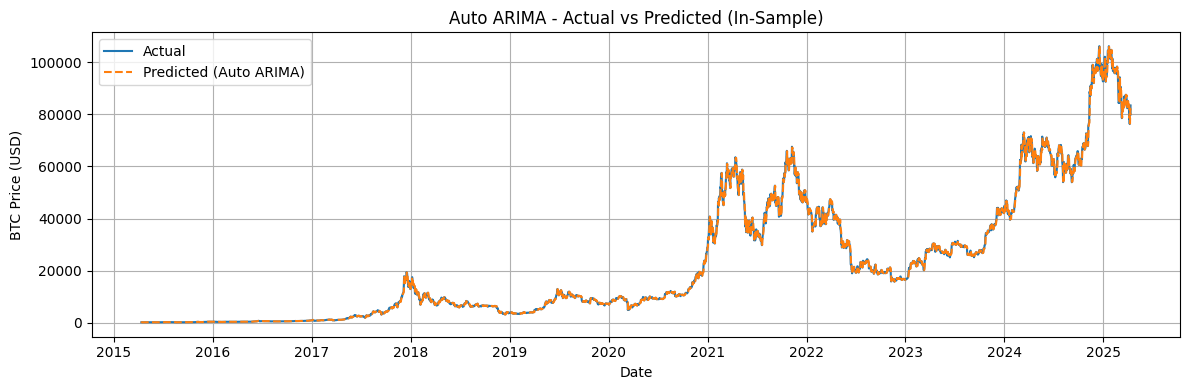

In [9]:
# Lakukan prediksi in-sample dari model yang dihasilkan auto_arima
auto_pred = auto_model.predict_in_sample()

# Visualisasikan hasil prediksi dibandingkan dengan harga aktual
plt.figure(figsize=(12, 4))
plt.plot(df['Close'], label='Actual')
plt.plot(df.index, auto_pred, label='Predicted (Auto ARIMA)', linestyle='--')
plt.title("Auto ARIMA - Actual vs Predicted (In-Sample)")
plt.xlabel("Date")
plt.ylabel("BTC Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 🔹 Soal 3-Step 3: Evaluasi Model Auto ARIMA

model auto ARIMA selesai melakukan prediksi, menggunakan tiga metrik utama:

- **MAE**: Mean Absolute Error
- **RMSE**: Root Mean Squared Error
- **MAPE**: Mean Absolute Percentage Error

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Hitung nilai evaluasi
auto_mae = mean_absolute_error(df['Close'], auto_pred)
auto_rmse = np.sqrt(mean_squared_error(df['Close'], auto_pred))
auto_mape = np.mean(np.abs((df['Close'] - auto_pred) / df['Close'])) * 100

# Cetak hasil
print(" [Auto ARIMA] MAE:", round(auto_mae, 2))
print(" [Auto ARIMA] RMSE:", round(auto_rmse, 2))
print("[Auto ARIMA] MAPE:", round(auto_mape, 2), "%")


 [Auto ARIMA] MAE: 522.38
 [Auto ARIMA] RMSE: 1045.33
[Auto ARIMA] MAPE: 2.37 %


## 🔹Tabel Perbandingan ARIMA Manual vs Auto ARIMA


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Actual
actual = df['Close'].iloc[1:]

# Prediksi manual (sudah tersedia sebelumnya)
manual_pred = pred
manual_mae = mean_absolute_error(actual, manual_pred)
manual_rmse = np.sqrt(mean_squared_error(actual, manual_pred))
manual_mape = np.mean(np.abs((actual - manual_pred) / actual)) * 100
manual_aic = model_fit.aic
manual_model = f"ARIMA({p},{d},{q})"


# Prediksi auto (auto_pred), sudah align dengan df['Close']
auto_mae = mean_absolute_error(df['Close'], auto_pred)
auto_rmse = np.sqrt(mean_squared_error(df['Close'], auto_pred))
auto_mape = np.mean(np.abs((df['Close'] - auto_pred) / df['Close'])) * 100
auto_aic = auto_model.aic()
auto_model_name = str(auto_model.order)

# Buat DataFrame perbandingan
comparison = pd.DataFrame({
    "Metrik": ["MAE", "RMSE", "MAPE (%)", "AIC", "Model"],
    "ARIMA Manual": [round(manual_mae, 2), round(manual_rmse, 2), round(manual_mape, 2), round(manual_aic, 3), manual_model],
    "Auto ARIMA": [round(auto_mae, 2), round(auto_rmse, 2), round(auto_mape, 2), round(auto_aic, 3), f"ARIMA{auto_model_name}"]
})

comparison


Metrik  ARIMA Manual      Auto ARIMA
0       MAE        522.84          522.38
1      RMSE       1045.27         1045.33
2  MAPE (%)          2.34            2.37
3       AIC     61151.604       61146.962
4     Model  ARIMA(2,1,2)  ARIMA(1, 1, 0)

###  Interpretasi Hasil

- **MAE (Mean Absolute Error):**
  - Selisih rata-rata absolut antara prediksi dan nilai aktual hampir sama pada kedua model.
  - Auto ARIMA memiliki **sedikit keunggulan** dengan nilai error lebih kecil (`522.38` vs `522.84`).

- **RMSE (Root Mean Squared Error):**
  - Nilai RMSE kedua model sangat mirip, menunjukkan bahwa kedua model memberikan **prediksi yang cukup stabil**.

- **MAPE (Mean Absolute Percentage Error):**
  - Metrik ini menunjukkan seberapa besar persentase kesalahan rata-rata relatif terhadap nilai aktual.
  - ARIMA manual sedikit lebih unggul di sini (`2.34%` vs `2.37%`), namun perbedaan sangat kecil.

- **AIC (Akaike Information Criterion):**
  - Semakin kecil AIC, semakin baik model dari sisi keseimbangan antara kompleksitas dan akurasi.
  - Auto ARIMA memiliki AIC **lebih rendah** (`61146.962`), artinya **lebih optimal secara statistik** dibandingkan ARIMA manual.

---

### ✅ Kesimpulan

- Kedua model memberikan performa prediksi yang sangat mirip.
- Namun berdasarkan nilai **AIC** dan **MAE**, **Auto ARIMA dinilai lebih optimal** karena berhasil memilih model yang lebih sederhana (`ARIMA(1,1,0)`) dengan performa setara bahkan sedikit lebih baik daripada model manual yang lebih kompleks (`ARIMA(2,1,2)`).
- Auto ARIMA sangat bermanfaat untuk efisiensi eksplorasi model, terutama saat jumlah data besar atau parameter sulit dianalisis secara manual.

> 🔽 **Model terbaik untuk kasus ini: `Auto ARIMA (1,1,0)`**